## Sentiment Analysis

> Don't use a hammer to kill a fly

Since our dataset isn't that large we don't need complex neural networks and Bidirectional LSTMS to solve this task. Simple Machine Learning models with some appropriate preprocessing will yield the best results.


In this kernel, I will walk you through my approach of solving this problem by first performing some Exploratory Data Analysis and then training some models on it.


**Note**: I know the hackathon required us to solve the challenge using Pytorch. That's why I submitted my kernel by training a 3-Layer Dense NN using Pytorch. But this model led to a lower accuracy than what the models I use in this kernel will get. That is why I think it is best to change the rule for the hackathons and not make it mandatory to use Pytorch

### Step 1: Imports

In [1]:
from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Matplotlib forms basis for visualization in Python
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# We will use the Seaborn library
import seaborn as sns
sns.set()

import os, string
# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'
print(os.listdir('../input/'))

['test.csv', 'train.csv', 'sample_submission.csv']


### Step 2: Let's Import and Visualize the data

In [2]:
df = pd.read_csv('../input/train.csv')
df.head()

,Id,review,sentiment
0,0,"I have done a lot of international travel, bot...",1
1,1,One of the most frightening game experiences e...,1
2,2,I was amazingly impressed by this movie. It co...,1
3,3,"This film is stale, and misses the mark. It is...",0
4,4,At last!! Sandra Bullock is indeed a beautiful...,1


In [3]:
test_df = pd.read_csv('../input/test.csv')

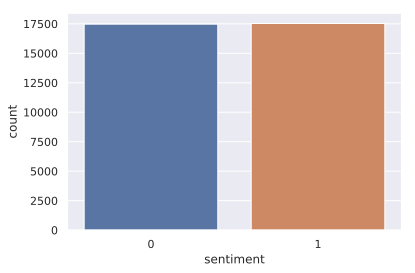

In [4]:
df['sentiment'].value_counts()

sns.countplot(x='sentiment', data=df)


As we can see, the dataset is already balanced with 17500 example for both negative and positive reviews.

Let's create some more features and visualize them to understand the data distribution.

In [5]:
df['char_count'] = df['review'].apply(len)
df['word_count'] = df['review'].apply(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count']+1)
df['punctuation_count'] = df['review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 

In [6]:
df.head()

,Id,review,sentiment,char_count,word_count,word_density,punctuation_count
0,0,"I have done a lot of international travel, bot...",1,854,163,5.207317,39
1,1,One of the most frightening game experiences e...,1,390,69,5.571429,9
2,2,I was amazingly impressed by this movie. It co...,1,1243,219,5.650000,45
3,3,"This film is stale, and misses the mark. It is...",0,378,76,4.909091,9
4,4,At last!! Sandra Bullock is indeed a beautiful...,1,663,110,5.972973,42


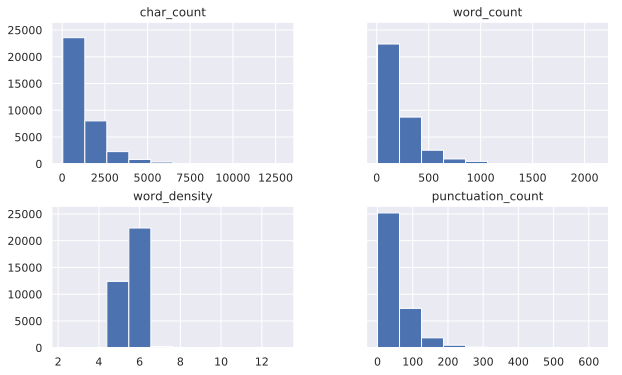

In [7]:
#df.hist(column=['char_count', 'word_count'])
features = ['char_count', 'word_count', 'word_density', 'punctuation_count']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharey=True)

for i, feature in enumerate(features):
    df.hist(column=feature, ax=axes.flatten()[i])


It's clear from the plots that the averate word density is between 4-6. Moreover, all three of char_count, word_count and punctuation_count have no irregularities and have a similar disrtibution (which they should have as they are correlated).

In [8]:
df[features].describe()

,char_count,word_count,word_density,punctuation_count
count,35000.000000,35000.000000,35000.000000,35000.000000
mean,1312.299257,231.627514,5.597969,52.741857
std,991.908965,171.679322,0.341171,44.001763
min,41.000000,8.000000,2.228956,0.000000
25%,699.000000,126.000000,5.375875,24.000000
50%,971.000000,173.000000,5.587302,40.000000
75%,1594.250000,282.000000,5.810321,68.000000
max,12930.000000,2125.000000,13.035714,625.000000


Let's display a boxplot of the word count to get an intuition about the average word count of a review.

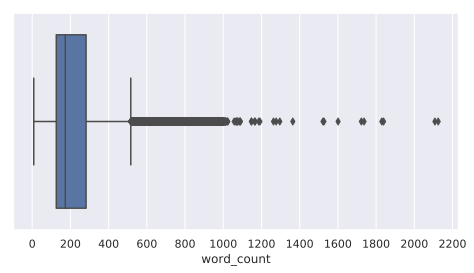

In [9]:
fig, ax = plt.subplots()
sns.boxplot(df['word_count'], order=range(0,max(df['word_count'])), ax=ax)

ax.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
fig.set_size_inches(8, 4)
plt.show()

As we can see from the boxplot, the 50th percentile of the word_count is somewhere below 200. However there are still a large number of outliers. We can also later try to train a model without the outliers and try to check it's accuracy.

> ### Step 3: Creating the Train and Validation Dataset and preparing them for the models

In [10]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

X_train, X_val, y_train, y_val = train_test_split(df['review'], df['sentiment'], test_size=0.3,
random_state=17)

Here we try three types of preprocessing,
1. Converting the text to tfidf word vectors.
2. Converting the text to tfidf ngram vectors.
3. Converting the text to tfidf character vectors.

In [11]:
# Converting X_train and X_val to tfidf vectors (since out models can't take text data is input)
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['review'])
xtrain_tfidf =  tfidf_vect.transform(X_train)
xvalid_tfidf =  tfidf_vect.transform(X_val)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(df['review'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_val)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(df['review'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_train) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_val) 

# Also creating for the X_test which is essentially test_df['review'] column
xtest_tfidf =  tfidf_vect.transform(test_df['review'])
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(test_df['review'])
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(test_df['review']) 

We also create the Count vectors

In [12]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df['review'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(X_train)
xvalid_count =  count_vect.transform(X_val)
xtest_count = count_vect.transform(test_df['review'])

### Step 4: Creating three models and calculating their accuracy

In [13]:
model1 = linear_model.LogisticRegression()
model1.fit(xtrain_count, y_train)
accuracy=model1.score(xvalid_count, y_val)
print('Accuracy Count LR:', accuracy)
test_pred1=model1.predict(xtest_count)

model2 = linear_model.LogisticRegression()
model2.fit(xtrain_tfidf, y_train)
accuracy=model2.score(xvalid_tfidf, y_val)
print('Accuracy TFIDF LR:', accuracy)
test_pred2=model2.predict(xtest_tfidf)

model3 = linear_model.LogisticRegression()
model3.fit(xtrain_tfidf_ngram, y_train)
accuracy = model3.score(xvalid_tfidf_ngram, y_val)
print('Accuracy TFIDF NGRAM LR:', accuracy)
test_pred3 = model3.predict(xtest_tfidf_ngram)

Accuracy Count LR: 0.8828571428571429
Accuracy TFIDF LR: 0.8873333333333333
Accuracy TFIDF NGRAM LR: 0.8568571428571429


We will ensemble these 3 models, i.e take the most agreed upon label as the true label.

In [14]:
final_pred = np.array([])
for i in range(0,len(test_df['review'])):
    final_pred = np.append(final_pred, np.argmax(np.bincount([test_pred1[i], test_pred2[i], test_pred3[i]])))

### Step 5: Creating Submission DF 

In [15]:
sub_df = pd.DataFrame()
sub_df['Id'] = test_df['Id']
sub_df['sentiment'] = [int(i) for i in final_pred]

In [16]:
sub_df.head()

,Id,sentiment
0,35000,1
1,35001,1
2,35002,0
3,35003,0
4,35004,0


In [17]:
sub_df.to_csv('my_submission.csv', index=False)